# Normalized Difference Vegetation Index

## 1 Overview

- **Main ideas:**
    - This notebook makes the GIMMS NDVI data **spatially** compatible with ERA-INTERIM data.
    - First we need to create a regrid file using xesmf packages. This file translates from original GIMMS NDVI grid (2610 x 4320) to ERA-INTERIM one (241 x 480).
    - Then we create the new files using the above regridder file. **Please note that we do not make any manipulations before regridding**. It is necessary to perform a linear transformation and a cutting into data in order to retrieve valid NDVI values. This step is done in the new regridded files.
    - With the regridded files, first we make the transformation to retrieve valid range of NDVI data, and then we calculate the monthly means creating a netcdf file for each year. These final files will be compatible with monthly means from ERA-INTERIM variables.  
    - Finally, we read these monthly means files in order to visualize some data.

## 2 Initial setup

In [1]:
# Load packages
import sys
import glob
import os
import warnings

import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")

%matplotlib inline

In [2]:
print("Python:", sys.version)
print("Xarray:", xr.__version__)
print("Pandas:", pd.__version__)

Python: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
Xarray: 0.15.1
Pandas: 1.0.3


In [3]:
# My repository.
repository = "/home/alex/Dropbox/repositories/cdlearn/"

In [4]:
# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Work in progress.
from cdlearn.maps import south_america_months

In [5]:
# Original data.
FOLDER_IN = "/media/alex/ALEXDATA/data_sets/GIMMS/NDVI/"

# All files there.
FILES_IN = sorted(glob.glob(FOLDER_IN + "*[0-9].nc4"))

In [6]:
# South America.
loni, lonf, lati, latf = -90, -30, -60, 20

## 3 Explore single file

In [7]:
%%time

# As xarray Dataset object. 
DS = xr.open_dataset(FILES_IN[0])

# Show it.
print(DS)

<xarray.Dataset>
Dimensions:     (lat: 2160, lon: 4320, time: 12)
Coordinates:
  * lon         (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat         (lat) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * time        (time) float64 7.0 7.5 8.0 8.5 9.0 ... 10.5 11.0 11.5 12.0 12.5
Data variables:
    satellites  (time) int16 ...
    ndvi        (time, lat, lon) float32 ...
    percentile  (time, lat, lon) int16 ...
Attributes:
    FileName:              ndvi3g_geo_v1_1981_0712.nc4
    Institution:           NASA/GSFC GIMMS
    Data:                  NDVI3g version 1
    Reference:             1. Pinzon, J.E.; Tucker, C.J.                     ...
    CommentsVersion1:      version1 includes two major fixes (a and b), and t...
    Temporalrange:         1981-07-01 -> 2015-12-31
    Year:                  1981.0
    RangeSemester:         Jul 1 - Dec 31 (7:0.5:12.5)
    SpatialResolution:     1/12 x 1/12 degrees
    TemporalResolution:    1/24 a year
  

## 4 Create regridder file

In [8]:
# In accordance with ERA-INTERIM pos-processed data (after shifting longitudes from 0 ... 360
# to -180 ... 180).
NEW_GRID = xr.Dataset({
    "lat": (["lat"], np.arange(90.00, -90.01, -0.75)),
    "lon": (["lon"], np.arange(-180.00, 180.00, 0.75)),
})

NEW_GRID

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
Data variables:
    *empty*

**The cell bellow takes some time (~3min) and consumes a lot of ram, but the netcdf file needs to be created just once.** 

In [9]:
%%time

# Regridder object.
REGRIDDER = xe.Regridder(
    ds_in=DS, 
    ds_out=NEW_GRID, 
    method="bilinear", 
    periodic=True, 
    reuse_weights=True,
    filename="ndvi_regridder.nc"
)

Reuse existing file: ndvi_regridder.nc
CPU times: user 125 ms, sys: 83.9 ms, total: 209 ms
Wall time: 209 ms


## 5 Create new regridded files

**These new files will be in the original range of values for the ndvi variable. Later, it is necessary to perform a linear transformation to the valid range [-0.3, 1.0].**

In [10]:
%%time

# Message.
print("In", FOLDER_IN + " :")

# Loop over input files.
for FILE_IN in FILES_IN:
    
    # Extract input file name without extension.
    name = os.path.basename(FILE_IN) # File name with extension.
    name = os.path.splitext(name)[0] # File name withou extension.
    
    # Output file path.
    out_file_name = name + "_regridded" + ".nc4"
    out_file_path = FOLDER_IN + out_file_name    
    
    # Continue only if data file does not exist yet.
    if not os.path.isfile(out_file_path):    
    
        # Message.
        print("Creating", out_file_name, "...")
        
        # Read data.
        DS = xr.open_dataset(FILE_IN) # Xarray Dataset object.
        DA = DS.ndvi                  # Xarray DataArray object.
                
        # Regrid NDVI data.
        DAreg = REGRIDDER(DA)
    
        # Export regridded data intothe input folder. 
        DAreg.to_netcdf(path=out_file_path)
        
    else:
        
        # Message.
        print("Warning:", out_file_name, "has already been created!")

In /media/alex/ALEXDATA/data_sets/GIMMS/NDVI/ :
Creating ndvi3g_geo_v1_1981_0712_regridded.nc4 ...
Creating ndvi3g_geo_v1_1982_0106_regridded.nc4 ...
Creating ndvi3g_geo_v1_1982_0712_regridded.nc4 ...
Creating ndvi3g_geo_v1_1983_0106_regridded.nc4 ...
Creating ndvi3g_geo_v1_1983_0712_regridded.nc4 ...
Creating ndvi3g_geo_v1_1984_0106_regridded.nc4 ...
Creating ndvi3g_geo_v1_1984_0712_regridded.nc4 ...
Creating ndvi3g_geo_v1_1985_0106_regridded.nc4 ...
Creating ndvi3g_geo_v1_1985_0712_regridded.nc4 ...
Creating ndvi3g_geo_v1_1986_0106_regridded.nc4 ...
Creating ndvi3g_geo_v1_1986_0712_regridded.nc4 ...
Creating ndvi3g_geo_v1_1987_0106_regridded.nc4 ...
Creating ndvi3g_geo_v1_1987_0712_regridded.nc4 ...
Creating ndvi3g_geo_v1_1988_0106_regridded.nc4 ...
Creating ndvi3g_geo_v1_1988_0712_regridded.nc4 ...
Creating ndvi3g_geo_v1_1989_0106_regridded.nc4 ...
Creating ndvi3g_geo_v1_1989_0712_regridded.nc4 ...
Creating ndvi3g_geo_v1_1990_0106_regridded.nc4 ...
Creating ndvi3g_geo_v1_1990_0712_r

## 6 Create files for monthly mmeans of valid NDVI data

In [11]:
%%time

# Read all regridded data.
FILES_RE_IN = sorted(glob.glob(FOLDER_IN + "*regridded.nc4"))

# Load meta-data.
DSreg = xr.open_mfdataset(FILES_RE_IN, combine="nested", concat_dim="time")

# Show it.
print(DSreg)

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480, time: 828)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
  * time     (time) float64 7.0 7.5 8.0 8.5 9.0 9.5 ... 10.5 11.0 11.5 12.0 12.5
Data variables:
    ndvi     (time, lat, lon) float64 dask.array<chunksize=(12, 241, 480), meta=np.ndarray>
CPU times: user 832 ms, sys: 69.6 ms, total: 902 ms
Wall time: 1.93 s


In [12]:
%%time

# Scale factor and valid range of data [-0.3, 1.0].
DAreg = (DSreg.ndvi / 10000)
DAreg = DAreg.where(cond=(DAreg > -0.3), other=-0.3)
DAreg = DAreg.where(cond=(DAreg < 1.0), other=1.0)

# Make time coordinate as datetime. SemiMonthBegin 'SMS' 15th (or other day_of_month) and 
# calendar month begin.See pandas documentation: 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
DAreg["time"] = pd.date_range(start="1981-07-01", freq="SMS", periods=DAreg.time.size)

# Show it.
print(DAreg)

<xarray.DataArray 'ndvi' (time: 828, lat: 241, lon: 480)>
dask.array<where, shape=(828, 241, 480), dtype=float64, chunksize=(12, 241, 480), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
  * time     (time) datetime64[ns] 1981-07-01 1981-07-15 ... 2015-12-15
CPU times: user 78 ms, sys: 739 µs, total: 78.7 ms
Wall time: 82.7 ms


In [13]:
%%time

# Resample data as monthly means.
DAreg_mm = DAreg.resample(time="MS").mean("time")

# Show it.
print(DAreg_mm)

<xarray.DataArray 'ndvi' (time: 414, lat: 241, lon: 480)>
dask.array<stack, shape=(414, 241, 480), dtype=float64, chunksize=(1, 241, 480), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2015-12-01
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
CPU times: user 909 ms, sys: 6.64 ms, total: 915 ms
Wall time: 930 ms


In [14]:
%%time

# Output folder.
FOLDER_OUT = "/media/alex/ALEXDATA/data_sets/GIMMS/NDVI_mmeans/"

# Pandas date times.
dates = pd.to_datetime(DAreg_mm.time.values)

# Range of dates. 
years = dates.year.unique()
number_of_iterations = years.size 

# Root for file name.
ROOT = "ndvi_regridded_mmeans_"

# Message.
print("In", FOLDER_OUT + " :")

# Loop over each month in each year.
for year in years:
        
    # Data file.
    FILE_NAME = ROOT + "{0:04d}.nc4".format(year)
    FILE_PATH = FOLDER_OUT + FILE_NAME
        
    # Continue only if data file does not exist yet.
    if not os.path.isfile(FILE_PATH):
    
        # Message.
        print("Creating", FILE_NAME, "...") 
    
        # Select data corresponding to this date.
        DATA_ARRAY = DAreg_mm.sel(time=str(year))
            
        # Export selected data as a netcdf file.
        DATA_ARRAY.to_netcdf(FILE_PATH)
        
    else:
        
        # Message.
        print("Warning:", FILE_NAME, "has already been created!")

In /media/alex/ALEXDATA/data_sets/GIMMS/NDVI_mmeans/ :
Creating ndvi_regridded_mmeans_1981.nc4 ...
Creating ndvi_regridded_mmeans_1982.nc4 ...
Creating ndvi_regridded_mmeans_1983.nc4 ...
Creating ndvi_regridded_mmeans_1984.nc4 ...
Creating ndvi_regridded_mmeans_1985.nc4 ...
Creating ndvi_regridded_mmeans_1986.nc4 ...
Creating ndvi_regridded_mmeans_1987.nc4 ...
Creating ndvi_regridded_mmeans_1988.nc4 ...
Creating ndvi_regridded_mmeans_1989.nc4 ...
Creating ndvi_regridded_mmeans_1990.nc4 ...
Creating ndvi_regridded_mmeans_1991.nc4 ...
Creating ndvi_regridded_mmeans_1992.nc4 ...
Creating ndvi_regridded_mmeans_1993.nc4 ...
Creating ndvi_regridded_mmeans_1994.nc4 ...
Creating ndvi_regridded_mmeans_1995.nc4 ...
Creating ndvi_regridded_mmeans_1996.nc4 ...
Creating ndvi_regridded_mmeans_1997.nc4 ...
Creating ndvi_regridded_mmeans_1998.nc4 ...
Creating ndvi_regridded_mmeans_1999.nc4 ...
Creating ndvi_regridded_mmeans_2000.nc4 ...
Creating ndvi_regridded_mmeans_2001.nc4 ...
Creating ndvi_regridd

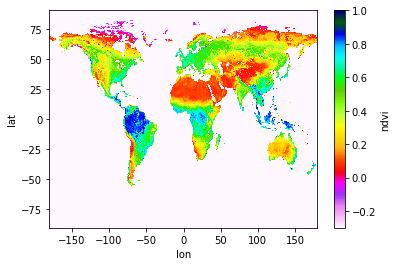

In [15]:
# Does it seem OK?
DATA_ARRAY.mean("time").plot(vmin=-0.3, vmax=1.0, cmap=plt.cm.gist_ncar_r)

## 7 Read and visualize final files

In [16]:
%%time

# Load in memory.
DSreg_mm = xr.open_mfdataset(sorted(glob.glob(FOLDER_OUT + "*.nc4"))).load()
DAreg_mm = DSreg_mm.ndvi

# Show it.
print(DSreg_mm)

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480, time: 414)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
  * time     (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2015-12-01
Data variables:
    ndvi     (time, lat, lon) float64 -0.3 -0.3 -0.3 -0.3 ... -0.3 -0.3 -0.3
CPU times: user 431 ms, sys: 468 ms, total: 899 ms
Wall time: 923 ms


In [17]:
%%time

# Extract data.
DATA = DAreg_mm.groupby("time.month").mean("time")

CPU times: user 316 ms, sys: 86.6 ms, total: 402 ms
Wall time: 407 ms


CPU times: user 31.6 s, sys: 22.1 ms, total: 31.7 s
Wall time: 26.5 s


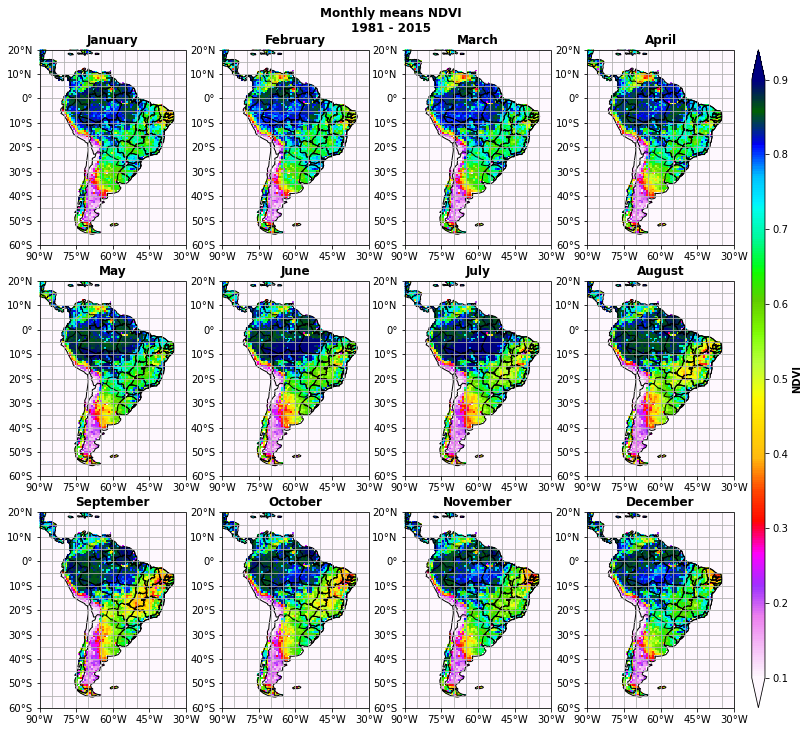

In [18]:
%%time

# Grid of maps.
axgr = south_america_months(
    title="Monthly means NDVI\n1981 - 2015"
)

# Make maps.
for index, axis in enumerate(axgr):
    
    # Plot data on these maps.
    plotmap = DATA[index].plot(
        ax=axis,
        vmin=0.1,
        vmax=0.9,
        cmap=plt.cm.gist_ncar_r,
        add_colorbar=False,
        add_labels=False
    )
    
# Commom color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[0],  
    extend="both"  
)    
_ = cb.set_label("NDVI", weight="bold") 

Please compare the above time series with the one shown in Figure 1 of Papagiannopoulou, C.et al. 2017.

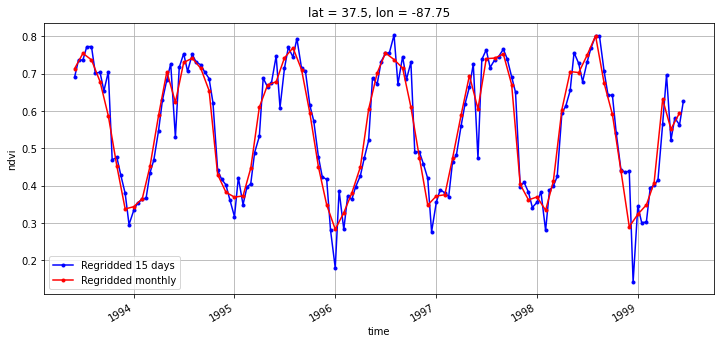

In [19]:
plt.figure(figsize=(12, 5))
selection = dict(lon=-87.5, lat=37.5, method="nearest")
DAreg.sel(**selection).sel(time=slice("1993-06", "1999-06")).\
      plot(label="Regridded 15 days", marker=".", color="blue")
DAreg_mm.sel(**selection).sel(time=slice("1993-06", "1999-06")).\
         plot(label="Regridded monthly", marker=".", color="red")
plt.grid()
plt.legend();